In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Работаем на устройстве: {device}")

Работаем на устройстве: cuda


In [3]:
# ==========================================
# 1. ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ==========================================
def load_and_process_data(csv_path, target_col='ph_h2o'):
    print("Чтение файла...")
    df = pd.read_csv(csv_path, low_memory=False)
    df = df.dropna(subset=[target_col])

    # Выделяем Спектральные колонки (NIR)
    def is_spectral_col(col_name):
        try:
            float(col_name)
            return True
        except ValueError:
            return False

    spectral_cols = [c for c in df.columns if is_spectral_col(c)]
    spectral_cols = sorted(spectral_cols, key=lambda x: float(x))

    print(f"Найдено спектральных каналов: {len(spectral_cols)} (от {spectral_cols[0]} до {spectral_cols[-1]})")

    tabular_features = [
        'lat.ycntr',           # Широта
        'long.xcntr',          # Долгота
        'lay.depth.to.top',    # Глубина начала слоя
        'lay.depth.to.bottom', # Глубина конца слоя
    ]

    for col in tabular_features:
        if col in df.columns:
            df[col] = df[col].fillna(0)
        else:
            print(f"Внимание: колонка {col} не найдена, заполняем нулями.")
            df[col] = 0

    X_spec = df[spectral_cols].values.astype(np.float32)
    X_tab = df[tabular_features].values.astype(np.float32)
    y = df[target_col].values.astype(np.float32).reshape(-1, 1)

    return X_spec, X_tab, y

In [4]:
filename = "/content/Neospectra_WoodwellKSSL_avg_soil+site+NIR.csv"

In [5]:
# Предсказываем pH (ph_h2o).
try:
    X_spec, X_tab, y = load_and_process_data(filename, target_col='ph_h2o')
except FileNotFoundError:
    print("Файл не найден! Генерируем синтетические данные для теста кода...")
    N_SAMPLES = 1000
    X_spec = np.random.rand(N_SAMPLES, 500).astype(np.float32)
    X_tab = np.random.rand(N_SAMPLES, 4).astype(np.float32)
    y = np.random.rand(N_SAMPLES, 1).astype(np.float32) * 14

X_spec_train, X_spec_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_spec, X_tab, y, test_size=0.2, random_state=42
)

scaler_tab = StandardScaler()
X_tab_train = scaler_tab.fit_transform(X_tab_train)
X_tab_test = scaler_tab.transform(X_tab_test)

scaler_spec = StandardScaler()
X_spec_train = scaler_spec.fit_transform(X_spec_train)
X_spec_test = scaler_spec.transform(X_spec_test)

Чтение файла...
Найдено спектральных каналов: 257 (от 1350.000323 до 2549.999982)


In [7]:
# ==========================================
# 2. DATASET (PyTorch)
# ==========================================
class SoilSpectraDataset(Dataset):
    def __init__(self, specs, tabs, targets):
        self.specs = specs
        self.tabs = tabs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        spec = torch.tensor(self.specs[idx]).unsqueeze(0)
        tab = torch.tensor(self.tabs[idx])
        target = torch.tensor(self.targets[idx])
        return spec, tab, target

train_dataset = SoilSpectraDataset(X_spec_train, X_tab_train, y_train)
test_dataset = SoilSpectraDataset(X_spec_test, X_tab_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
# ==========================================
# 3. АРХИТЕКТУРА МОДЕЛИ (1D CNN + MLP)
# ==========================================
class HybridSoilNet(nn.Module):
    def __init__(self, n_wavelengths, n_tab_features):
        super(HybridSoilNet, self).__init__()

        # --- Ветка 1: 1D CNN для Спектров ---
        self.spec_branch = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # --- Ветка 2: MLP для Таблиц ---
        self.tab_branch = nn.Sequential(
            nn.Linear(n_tab_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        # Вход: 64 (от спектра) + 16 (от таблицы) = 80
        self.fusion = nn.Sequential(
            nn.Linear(64 + 16, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1) # Выход: одно число (pH)
        )

    def forward(self, spec, tab):
        spec_out = self.spec_branch(spec)
        spec_out = spec_out.view(spec_out.size(0), -1)

        tab_out = self.tab_branch(tab)

        combined = torch.cat((spec_out, tab_out), dim=1)
        output = self.fusion(combined)
        return output

In [9]:
n_wavelengths = X_spec.shape[1]
n_tab_features = X_tab.shape[1]

model = HybridSoilNet(n_wavelengths, n_tab_features).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# ==========================================
# 4. ОБУЧЕНИЕ
# ==========================================
print("Начинаем обучение...")

train_losses = []
test_rmses = []
predictions = []
actuals = []

epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for specs, tabs, targets in train_loader:
        specs, tabs, targets = specs.to(device), tabs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(specs, tabs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    model.eval()
    mse_sum = 0
    total = 0
    with torch.no_grad():
        for specs, tabs, targets in test_loader:
            specs, tabs, targets = specs.to(device), tabs.to(device), targets.to(device)
            outputs = model(specs, tabs)
            mse_sum += criterion(outputs, targets).item() * specs.size(0)
            total += specs.size(0)

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())

    rmse = np.sqrt(mse_sum / total)
    test_rmses.append(rmse)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test RMSE: {rmse:.4f}")



Начинаем обучение...
Epoch 1/50 | Train Loss: 1.9473 | Test RMSE: 1.0847
Epoch 2/50 | Train Loss: 1.8404 | Test RMSE: 0.9944
Epoch 3/50 | Train Loss: 1.8134 | Test RMSE: 0.9718
Epoch 4/50 | Train Loss: 1.7913 | Test RMSE: 0.9891
Epoch 5/50 | Train Loss: 1.7703 | Test RMSE: 0.9527
Epoch 6/50 | Train Loss: 1.7600 | Test RMSE: 0.9611
Epoch 7/50 | Train Loss: 1.7445 | Test RMSE: 0.9652
Epoch 8/50 | Train Loss: 1.7194 | Test RMSE: 0.9540
Epoch 9/50 | Train Loss: 1.6885 | Test RMSE: 0.9327
Epoch 10/50 | Train Loss: 1.7504 | Test RMSE: 0.9421
Epoch 11/50 | Train Loss: 1.6959 | Test RMSE: 0.9255
Epoch 12/50 | Train Loss: 1.6251 | Test RMSE: 0.9223
Epoch 13/50 | Train Loss: 1.6604 | Test RMSE: 0.9255
Epoch 14/50 | Train Loss: 1.6259 | Test RMSE: 0.9275
Epoch 15/50 | Train Loss: 1.6010 | Test RMSE: 0.9325
Epoch 16/50 | Train Loss: 1.6454 | Test RMSE: 0.9240
Epoch 17/50 | Train Loss: 1.6526 | Test RMSE: 0.9488
Epoch 18/50 | Train Loss: 1.6241 | Test RMSE: 0.9748
Epoch 19/50 | Train Loss: 1.5565 |

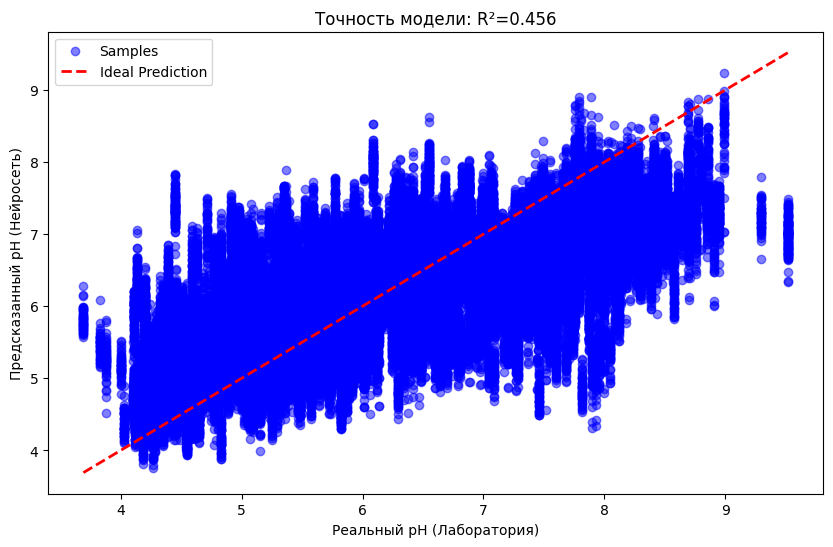

In [14]:
from sklearn.metrics import r2_score, mean_absolute_error
r2 = r2_score(actuals, predictions)
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(actuals, predictions, alpha=0.5, color='blue', label='Samples')

# Линия идеального предсказания (y = x)
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel("Реальный pH (Лаборатория)")
plt.ylabel("Предсказанный pH (Нейросеть)")
plt.title(f"Точность модели: R²={r2:.3f}")
plt.legend()
plt.show()

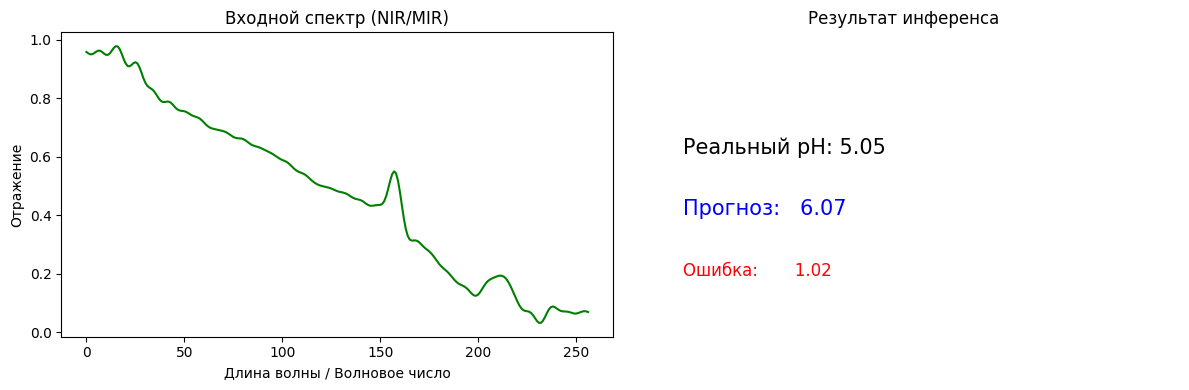

In [15]:
def predict_single_sample(model, new_spectrum, new_tabular, scaler_s, scaler_t):
    """
    new_spectrum: numpy array (1D) - сырой спектр
    new_tabular: numpy array (1D) - сырые табличные данные
    """
    model.eval()

    # масштабирование
    spec_scaled = scaler_s.transform(new_spectrum.reshape(1, -1))
    tab_scaled = scaler_t.transform(new_tabular.reshape(1, -1))

    spec_tensor = torch.tensor(spec_scaled, dtype=torch.float32).unsqueeze(1).to(device) # (1, 1, features)
    tab_tensor = torch.tensor(tab_scaled, dtype=torch.float32).to(device)

    with torch.no_grad():
        prediction = model(spec_tensor, tab_tensor)

    return prediction.item()

# Берем случайный образец из теста (до масштабирования) как "новый"
sample_idx = 5
sample_spec = X_spec_test[sample_idx]
sample_tab = X_tab_test[sample_idx]
true_value = y_test[sample_idx][0]

predicted_ph = predict_single_sample(model, sample_spec, sample_tab, scaler_spec, scaler_tab)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(sample_spec, color='green')
plt.title("Входной спектр (NIR/MIR)")
plt.xlabel("Длина волны / Волновое число")
plt.ylabel("Отражение")

plt.subplot(1, 2, 2)
plt.text(0.1, 0.6, f"Реальный pH: {true_value:.2f}", fontsize=15)
plt.text(0.1, 0.4, f"Прогноз:   {predicted_ph:.2f}", fontsize=15, color='blue')
plt.text(0.1, 0.2, f"Ошибка:       {abs(true_value - predicted_ph):.2f}", fontsize=12, color='red')
plt.axis('off')
plt.title("Результат инференса")

plt.tight_layout()
plt.show()